In [1]:
print("hello world")

hello world


In [2]:
# Install required packages
!pip install torch torchvision numpy matplotlib -q

print("✓ All packages installed successfully!")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
✓ All packages installed successfully!


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
from collections import deque
import random
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [29]:
# Cell 2.5: Setup for Apple Silicon (M4 Pro)
import torch

# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Apple Silicon GPU (MPS)")
    print(f"  Device: {device}")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✓ Using NVIDIA GPU")
else:
    device = torch.device("cpu")
    print("⚠ Using CPU (slower)")

print(f"\nCurrent device: {device}")

# Set default tensor type for faster operations
if device.type == "mps":
    torch.set_default_device(device)
    print("✓ Default tensors will be created on MPS")

✓ Using Apple Silicon GPU (MPS)
  Device: mps

Current device: mps
✓ Default tensors will be created on MPS


In [30]:
class LowerTransformer(nn.Module):
    """Aggregates observations, actions, and rewards from target and neighbors"""
    def __init__(self, d_model=64, nhead=4, num_layers=3, n_neighbors=4):
        super().__init__()
        self.d_model = d_model
        self.n_neighbors = n_neighbors
        
        # Separate embeddings for o, a, r
        self.obs_embed = nn.Linear(25, d_model)
        self.action_embed = nn.Linear(8, d_model)
        self.reward_embed = nn.Linear(1, d_model)
        
        # Decision token
        self.decision_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Position embedding
        self.pos_embed = nn.Parameter(torch.randn(1, 3*(1+n_neighbors)+1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model*4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, obs, actions, rewards, mask=None):
        batch_size = obs.shape[0]
        
        # Embed o, a, r separately
        obs_emb = self.obs_embed(obs)
        act_emb = self.action_embed(actions)
        rew_emb = self.reward_embed(rewards)
        
        # Concatenate along sequence dimension
        seq = torch.stack([obs_emb, act_emb, rew_emb], dim=2)
        seq = seq.reshape(batch_size, -1, self.d_model)
        
        # Prepend decision token
        decision = self.decision_token.expand(batch_size, -1, -1)
        seq = torch.cat([decision, seq], dim=1)
        
        # Add positional embedding
        seq = seq + self.pos_embed
        
        # Apply transformer
        out = self.transformer(seq)
        
        return out[:, 0, :]  # Return decision token output

print("✓ Lower Transformer defined")

✓ Lower Transformer defined


In [31]:
class UpperTransformer(nn.Module):
    """Learns scenario-agnostic decision policies across timesteps"""
    def __init__(self, d_model=64, d_output=128, nhead=4, num_layers=3, history_len=10):
        super().__init__()
        self.d_model = d_model
        self.d_output = d_output
        self.history_len = history_len
        
        # Project lower transformer output
        self.input_proj = nn.Linear(d_model, d_output)
        
        # Position embedding
        self.pos_embed = nn.Parameter(torch.randn(1, history_len, d_output))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_output,
            nhead=nhead,
            dim_feedforward=d_output*4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, lower_outputs):
        # Project to d_output dimension
        x = self.input_proj(lower_outputs)
        
        # Add positional embedding
        x = x + self.pos_embed
        
        # Apply transformer
        out = self.transformer(x)
        
        return out

print("✓ Upper Transformer defined")

✓ Upper Transformer defined


In [32]:
class DynamicPredictor(nn.Module):
    """Predicts next state embedding for learning environment dynamics"""
    def __init__(self, d_model=128, n_neighbors=4):
        super().__init__()
        
        input_dim = d_model + (1 + n_neighbors) * (8 + 1)
        
        self.predictor = nn.Sequential(
            nn.Linear(input_dim, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, d_model)
        )
        
    def forward(self, prev_embedding, actions, rewards):
        batch_size = prev_embedding.shape[0]
        
        actions_flat = actions.reshape(batch_size, -1)
        rewards_flat = rewards.reshape(batch_size, -1)
        
        x = torch.cat([prev_embedding, actions_flat, rewards_flat], dim=-1)
        
        return self.predictor(x)

print("✓ Dynamic Predictor defined")

✓ Dynamic Predictor defined


In [33]:
class XLight(nn.Module):
    """Complete X-Light model"""
    def __init__(self, 
                 obs_dim=25,
                 action_dim=8,
                 d_model=64,
                 d_output=128,
                 n_neighbors=4,
                 history_len=10,
                 nhead=4,
                 num_layers=3):
        super().__init__()
        
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.n_neighbors = n_neighbors
        self.history_len = history_len
        
        # Lower Transformer
        self.lower_transformer = LowerTransformer(
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            n_neighbors=n_neighbors
        )
        
        # Upper Transformer
        self.upper_transformer = UpperTransformer(
            d_model=d_model,
            d_output=d_output,
            nhead=nhead,
            num_layers=num_layers,
            history_len=history_len
        )
        
        # Dynamic Predictor
        self.dynamic_predictor = DynamicPredictor(
            d_model=d_output,
            n_neighbors=n_neighbors
        )
        
        # Actor (with residual connection)
        self.actor = nn.Sequential(
            nn.Linear(d_output + obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        
        # Critic
        self.critic = nn.Sequential(
            nn.Linear(d_output, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, obs_history, action_history, reward_history, 
                current_obs, neighbor_mask=None):
        batch_size = obs_history.shape[0]
        
        # Process each timestep through Lower Transformer
        lower_outputs = []
        for t in range(self.history_len):
            mask_t = neighbor_mask[:, t, :] if neighbor_mask is not None else None
            lower_out = self.lower_transformer(
                obs_history[:, t, :, :],
                action_history[:, t, :, :],
                reward_history[:, t, :, :],
                mask_t
            )
            lower_outputs.append(lower_out)
        
        lower_outputs = torch.stack(lower_outputs, dim=1)
        
        # Process through Upper Transformer
        upper_outputs = self.upper_transformer(lower_outputs)
        
        # Dynamic prediction for pretext task
        predicted_embeddings = []
        for t in range(self.history_len - 1):
            pred = self.dynamic_predictor(
                upper_outputs[:, t, :],
                action_history[:, t, :, :],
                reward_history[:, t, :, :]
            )
            predicted_embeddings.append(pred)
        predicted_embeddings = torch.stack(predicted_embeddings, dim=1) if predicted_embeddings else None
        
        # Use last timestep for decision
        last_embedding = upper_outputs[:, -1, :]
        
        # Actor with residual connection
        actor_input = torch.cat([last_embedding, current_obs], dim=-1)
        action_logits = self.actor(actor_input)
        
        # Critic
        value = self.critic(last_embedding)
        
        return action_logits, value, predicted_embeddings, upper_outputs[:, 1:, :]

print("✓ X-Light model defined")

✓ X-Light model defined


In [34]:
class SimpleTrafficEnv:
    """Simplified traffic simulation environment"""
    def __init__(self, n_intersections=16, n_neighbors=4, max_queue=50):
        self.n_intersections = n_intersections
        self.n_neighbors = n_neighbors
        self.max_queue = max_queue
        self.n_phases = 8
        
        # Create a grid topology (4x4)
        self.grid_size = int(np.sqrt(n_intersections))
        self.adjacency = self._create_grid_adjacency()
        
        self.reset()
        
    def _create_grid_adjacency(self):
        """Create adjacency matrix for grid topology"""
        adj = np.zeros((self.n_intersections, self.n_intersections))
        for i in range(self.n_intersections):
            row = i // self.grid_size
            col = i % self.grid_size
            
            neighbors = []
            if row > 0:
                neighbors.append((row-1) * self.grid_size + col)
            if row < self.grid_size - 1:
                neighbors.append((row+1) * self.grid_size + col)
            if col > 0:
                neighbors.append(row * self.grid_size + (col-1))
            if col < self.grid_size - 1:
                neighbors.append(row * self.grid_size + (col+1))
            
            for n in neighbors:
                adj[i, n] = 1
                
        return adj
    
    def reset(self):
        """Reset environment"""
        self.queues = np.random.randint(0, self.max_queue//2, 
                                       (self.n_intersections, 4))
        self.current_phase = np.zeros(self.n_intersections, dtype=int)
        self.phase_duration = np.zeros(self.n_intersections)
        self.time_step = 0
        
        return self._get_all_observations()
    
    def _get_all_observations(self):
        """Get observations for all intersections"""
        obs = []
        for i in range(self.n_intersections):
            obs.append(self._get_observation(i))
        return np.array(obs, dtype=np.float32)
    
    def _get_observation(self, intersection_id):
        """
        Get observation for a single intersection
        State features (25 total):
        - Queue lengths (4)
        - Current phase one-hot (8)
        - Occupancy (4)
        - Flow (4)
        - Number of stops (4)
        - Phase duration (1)
        """
        # Queue lengths (4)
        queues = self.queues[intersection_id] / self.max_queue
        
        # Current phase one-hot (8)
        phase_onehot = np.zeros(8, dtype=np.float32)
        phase_onehot[self.current_phase[intersection_id]] = 1
        
        # Occupancy (4) - simplified as normalized queues with noise
        occupancy = np.clip(queues + np.random.randn(4) * 0.1, 0, 1).astype(np.float32)
        
        # Flow (4) - random for simulation
        flow = (np.random.rand(4) * 0.5).astype(np.float32)
        
        # Number of stops (4) - approximated
        num_stops = (queues > 0.3).astype(np.float32)
        
        # Phase duration normalized (1)
        phase_dur = np.array([min(self.phase_duration[intersection_id] / 10.0, 1.0)], dtype=np.float32)
        
        # Concatenate all features: 4 + 8 + 4 + 4 + 4 + 1 = 25
        obs = np.concatenate([queues, phase_onehot, occupancy, flow, num_stops, phase_dur])
        
        return obs.astype(np.float32)
    
    def get_neighbors(self, intersection_id):
        """Get neighbor IDs for an intersection"""
        neighbors = np.where(self.adjacency[intersection_id] == 1)[0]
        
        if len(neighbors) < self.n_neighbors:
            neighbors = np.pad(neighbors, (0, self.n_neighbors - len(neighbors)), 
                             constant_values=-1)
        else:
            neighbors = neighbors[:self.n_neighbors]
            
        return neighbors
    
    def step(self, actions):
        """Execute actions for all intersections"""
        rewards = np.zeros(self.n_intersections, dtype=np.float32)
        
        for i in range(self.n_intersections):
            # Change phase if different
            if actions[i] != self.current_phase[i]:
                self.current_phase[i] = actions[i]
                self.phase_duration[i] = 0
            else:
                self.phase_duration[i] += 1
            
            # Simulate traffic flow
            active_movements = self._get_active_movements(actions[i])
            for movement in active_movements:
                reduction = np.random.poisson(3)
                self.queues[i, movement] = max(0, self.queues[i, movement] - reduction)
            
            # Add arriving vehicles to all approaches
            arrivals = np.random.poisson(2, 4)
            self.queues[i] += arrivals
            self.queues[i] = np.clip(self.queues[i], 0, self.max_queue)
            
            # Calculate reward (negative sum of queues and waiting time)
            queue_penalty = -np.sum(self.queues[i])
            wait_penalty = -np.sum(self.queues[i] ** 1.5) * 0.01
            rewards[i] = queue_penalty + wait_penalty
        
        self.time_step += 1
        done = self.time_step >= 360  # Shorter episodes for faster training
        
        obs = self._get_all_observations()
        
        return obs, rewards, done, {}
    
    def _get_active_movements(self, phase):
        """Get which movements are active for a phase"""
        phase_movements = {
            0: [0, 2], 1: [1, 3], 2: [0, 1], 3: [0, 3],
            4: [2, 1], 5: [2, 3], 6: [0], 7: [1],
        }
        return phase_movements.get(phase, [])

print("✓ Traffic Environment defined (FIXED - 25 features)")

# Test the observation shape
test_env = SimpleTrafficEnv()
test_obs = test_env.reset()
print(f"  Observation shape: {test_obs.shape}")
print(f"  Single observation length: {len(test_obs[0])}")

✓ Traffic Environment defined (FIXED - 25 features)
  Observation shape: (16, 25)
  Single observation length: 25


In [35]:
class RolloutBuffer:
    """Store trajectories for PPO training"""
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = []
        
    def push(self, obs_history, action_history, reward_history, 
             current_obs, action, reward, value, log_prob, neighbor_indices):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
            
        self.buffer.append({
            'obs_history': obs_history,
            'action_history': action_history,
            'reward_history': reward_history,
            'current_obs': current_obs,
            'action': action,
            'reward': reward,
            'value': value,
            'log_prob': log_prob,
            'neighbor_indices': neighbor_indices
        })
    
    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, len(self.buffer)))
    
    def clear(self):
        self.buffer = []
    
    def __len__(self):
        return len(self.buffer)


def compute_ppo_loss(model, batch, device, clip_epsilon=0.2, alpha=1.0, beta=0.5, gamma=1.0):
    """Compute PPO loss with dynamic prediction"""
    # Prepare batch data and move to device
    obs_hist = torch.stack([torch.FloatTensor(t['obs_history']) for t in batch]).to(device)
    act_hist = torch.stack([torch.FloatTensor(t['action_history']) for t in batch]).to(device)
    rew_hist = torch.stack([torch.FloatTensor(t['reward_history']) for t in batch]).to(device)
    current_obs = torch.stack([torch.FloatTensor(t['current_obs']) for t in batch]).to(device)
    actions = torch.LongTensor([t['action'] for t in batch]).to(device)
    rewards = torch.FloatTensor([t['reward'] for t in batch]).to(device)
    old_values = torch.FloatTensor([t['value'] for t in batch]).to(device)
    old_log_probs = torch.FloatTensor([t['log_prob'] for t in batch]).to(device)
    
    # Forward pass
    action_logits, values, predicted_embs, target_embs = model(
        obs_hist, act_hist, rew_hist, current_obs
    )
    
    # Actor loss (PPO)
    dist = Categorical(logits=action_logits)
    new_log_probs = dist.log_prob(actions)
    entropy = dist.entropy().mean()
    
    ratio = torch.exp(new_log_probs - old_log_probs)
    advantages = rewards - old_values.detach()
    
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
    actor_loss = -torch.min(surr1, surr2).mean()
    
    # Critic loss
    critic_loss = F.mse_loss(values.squeeze(), rewards)
    
    # Dynamic prediction loss
    if predicted_embs is not None and target_embs is not None:
        pred_loss = F.mse_loss(predicted_embs, target_embs.detach())
    else:
        pred_loss = torch.tensor(0.0).to(device)
    
    # Total loss
    total_loss = alpha * actor_loss + beta * critic_loss + gamma * pred_loss
    
    return total_loss, {
        'actor_loss': actor_loss.item(),
        'critic_loss': critic_loss.item(),
        'pred_loss': pred_loss.item() if isinstance(pred_loss, torch.Tensor) else pred_loss,
        'entropy': entropy.item()
    }

print("✓ Training components defined (FIXED with device)")

✓ Training components defined (FIXED with device)


In [36]:
class XLightTrainer:
    """Trainer for X-Light model"""
    def __init__(self, model, env, lr=3e-4, history_len=10, n_neighbors=4):
        self.model = model
        self.env = env
        self.history_len = history_len
        self.n_neighbors = n_neighbors
        self.device = next(model.parameters()).device  # Get model's device
        
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.buffer = RolloutBuffer(capacity=10000)
        
        self.obs_histories = {}
        self.action_histories = {}
        self.reward_histories = {}
        
        self._init_histories()
        
        print(f"✓ Trainer initialized on device: {self.device}")
    
    def _init_histories(self):
        """Initialize history buffers"""
        for i in range(self.env.n_intersections):
            self.obs_histories[i] = deque(maxlen=self.history_len)
            self.action_histories[i] = deque(maxlen=self.history_len)
            self.reward_histories[i] = deque(maxlen=self.history_len)
            
            # Initialize with proper shape: [1 + n_neighbors, feature_dim]
            dummy_obs = np.zeros((1 + self.n_neighbors, 25), dtype=np.float32)
            dummy_action = np.zeros((1 + self.n_neighbors, 8), dtype=np.float32)
            dummy_reward = np.zeros((1 + self.n_neighbors, 1), dtype=np.float32)
            
            for _ in range(self.history_len):
                self.obs_histories[i].append(dummy_obs.copy())
                self.action_histories[i].append(dummy_action.copy())
                self.reward_histories[i].append(dummy_reward.copy())
    
    def _get_neighbor_data(self, intersection_id, all_obs, all_actions, all_rewards):
        """Get data for target and neighbors"""
        neighbor_ids = self.env.get_neighbors(intersection_id)
        
        # Initialize arrays with proper shape
        obs_batch = np.zeros((1 + self.n_neighbors, 25), dtype=np.float32)
        action_batch = np.zeros((1 + self.n_neighbors, 8), dtype=np.float32)
        reward_batch = np.zeros((1 + self.n_neighbors, 1), dtype=np.float32)
        
        # Target intersection
        obs_batch[0] = all_obs[intersection_id]
        action_batch[0] = all_actions[intersection_id]
        reward_batch[0, 0] = all_rewards[intersection_id]
        
        # Neighbors
        for idx, nid in enumerate(neighbor_ids):
            if nid >= 0:  # Valid neighbor
                obs_batch[idx + 1] = all_obs[nid]
                action_batch[idx + 1] = all_actions[nid]
                reward_batch[idx + 1, 0] = all_rewards[nid]
            # else: already initialized with zeros
        
        return obs_batch, action_batch, reward_batch, neighbor_ids
    
    def train_episode(self):
        """Train for one episode"""
        obs = self.env.reset()
        done = False
        episode_reward = 0
        step_count = 0
        
        # Initialize action and reward arrays
        all_actions_onehot = np.zeros((self.env.n_intersections, 8), dtype=np.float32)
        all_actions_onehot[:, 0] = 1  # Start with phase 0
        all_rewards = np.zeros(self.env.n_intersections, dtype=np.float32)
        
        while not done:
            actions = []
            values = []
            log_probs = []
            
            for i in range(self.env.n_intersections):
                # Get neighbor data
                obs_data, action_data, reward_data, neighbor_ids = \
                    self._get_neighbor_data(i, obs, all_actions_onehot, all_rewards)
                
                # Update histories
                self.obs_histories[i].append(obs_data.copy())
                self.action_histories[i].append(action_data.copy())
                self.reward_histories[i].append(reward_data.copy())
                
                # Convert histories to arrays with explicit shape
                obs_hist_list = list(self.obs_histories[i])
                act_hist_list = list(self.action_histories[i])
                rew_hist_list = list(self.reward_histories[i])
                
                # Stack into arrays: [history_len, 1+n_neighbors, feature_dim]
                obs_hist_array = np.stack(obs_hist_list, axis=0)  # [10, 5, 25]
                act_hist_array = np.stack(act_hist_list, axis=0)  # [10, 5, 8]
                rew_hist_array = np.stack(rew_hist_list, axis=0)  # [10, 5, 1]
                
                # Convert to tensors and add batch dimension - MOVE TO DEVICE
                obs_hist = torch.FloatTensor(obs_hist_array).unsqueeze(0).to(self.device)
                act_hist = torch.FloatTensor(act_hist_array).unsqueeze(0).to(self.device)
                rew_hist = torch.FloatTensor(rew_hist_array).unsqueeze(0).to(self.device)
                current_obs_tensor = torch.FloatTensor(obs[i]).unsqueeze(0).to(self.device)
                
                # Get action from model
                with torch.no_grad():
                    action_logits, value, _, _ = self.model(
                        obs_hist, act_hist, rew_hist, current_obs_tensor
                    )
                    dist = Categorical(logits=action_logits)
                    action = dist.sample()
                    log_prob = dist.log_prob(action)
                
                # Move back to CPU for storage
                actions.append(action.cpu().item())
                values.append(value.cpu().item())
                log_probs.append(log_prob.cpu().item())
                
                # Store in buffer (will update reward later)
                self.buffer.push(
                    obs_history=obs_hist_array.copy(),
                    action_history=act_hist_array.copy(),
                    reward_history=rew_hist_array.copy(),
                    current_obs=obs[i].copy(),
                    action=action.cpu().item(),
                    reward=0.0,  # Will be updated
                    value=value.cpu().item(),
                    log_prob=log_prob.cpu().item(),
                    neighbor_indices=neighbor_ids
                )
            
            # Execute actions in environment
            next_obs, rewards, done, _ = self.env.step(actions)
            
            # Update rewards in buffer (last n_intersections entries)
            buffer_len = len(self.buffer)
            for i in range(self.env.n_intersections):
                if buffer_len > i:
                    idx = buffer_len - self.env.n_intersections + i
                    self.buffer.buffer[idx]['reward'] = float(rewards[i])
            
            # Update action one-hot encoding for next iteration
            all_actions_onehot = np.zeros((self.env.n_intersections, 8), dtype=np.float32)
            for i, a in enumerate(actions):
                all_actions_onehot[i, a] = 1.0
            
            all_rewards = rewards.astype(np.float32)
            obs = next_obs
            episode_reward += np.mean(rewards)
            step_count += 1
        
        return episode_reward, step_count
    
    def update(self, batch_size=64, n_updates=4):
        """Update model using PPO"""
        if len(self.buffer) < batch_size:
            return {}
        
        losses = {
            'actor_loss': [],
            'critic_loss': [],
            'pred_loss': [],
            'entropy': []
        }
        
        for _ in range(n_updates):
            batch = self.buffer.sample(batch_size)
            
            self.optimizer.zero_grad()
            loss, loss_dict = compute_ppo_loss(self.model, batch, device=self.device)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
            self.optimizer.step()
            
            for key in loss_dict:
                losses[key].append(loss_dict[key])
        
        avg_losses = {k: np.mean(v) for k, v in losses.items()}
        return avg_losses

print("✓ Trainer class defined (FIXED with device handling)")

✓ Trainer class defined (FIXED with device handling)


In [37]:
def train_xlight(n_episodes=50, update_interval=5, plot_live=True):
    """Main training loop with live plotting"""
    
    # Create environment
    env = SimpleTrafficEnv(n_intersections=16, n_neighbors=4)
    
    # Create model and move to device
    model = XLight(
        obs_dim=25,
        action_dim=8,
        d_model=64,
        d_output=128,
        n_neighbors=4,
        history_len=10,
        nhead=4,
        num_layers=3
    ).to(device)  # Move to MPS/GPU
    
    print(f"✓ Model created on {device}")
    print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Create trainer
    trainer = XLightTrainer(model, env, lr=3e-4)
    
    # Training loop
    episode_rewards = []
    actor_losses = []
    critic_losses = []
    
    print("\nStarting training...")
    print("=" * 50)
    
    import time
    start_time = time.time()
    
    for episode in range(n_episodes):
        # Train episode
        episode_reward, steps = trainer.train_episode()
        episode_rewards.append(episode_reward)
        
        # Update model
        if episode % update_interval == 0 and episode > 0:
            losses = trainer.update(batch_size=64, n_updates=4)
            
            if losses:
                actor_losses.append(losses['actor_loss'])
                critic_losses.append(losses['critic_loss'])
            
            elapsed = time.time() - start_time
            eps_per_sec = (episode + 1) / elapsed
            
            print(f"Episode {episode}/{n_episodes} | Reward: {episode_reward:.2f} | Steps: {steps} | Speed: {eps_per_sec:.2f} ep/s")
            if losses:
                print(f"  Actor Loss: {losses['actor_loss']:.4f} | Critic Loss: {losses['critic_loss']:.4f}")
                print(f"  Pred Loss: {losses['pred_loss']:.4f} | Entropy: {losses['entropy']:.4f}")
            
            # Live plotting
            if plot_live and episode > update_interval:
                clear_output(wait=True)
                
                fig, axes = plt.subplots(1, 2, figsize=(14, 4))
                
                # Plot rewards
                axes[0].plot(episode_rewards, label='Episode Reward', color='blue', alpha=0.6)
                if len(episode_rewards) >= 5:
                    axes[0].plot(np.convolve(episode_rewards, np.ones(5)/5, mode='valid'), 
                               label='Moving Avg (5)', color='red', linewidth=2)
                axes[0].set_xlabel('Episode')
                axes[0].set_ylabel('Average Reward')
                axes[0].set_title('Training Progress')
                axes[0].legend()
                axes[0].grid(True, alpha=0.3)
                
                # Plot losses
                if actor_losses:
                    x_loss = np.arange(len(actor_losses)) * update_interval
                    axes[1].plot(x_loss, actor_losses, label='Actor Loss', color='orange')
                    axes[1].plot(x_loss, critic_losses, label='Critic Loss', color='green')
                    axes[1].set_xlabel('Episode')
                    axes[1].set_ylabel('Loss')
                    axes[1].set_title('Training Losses')
                    axes[1].legend()
                    axes[1].grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                print(f"\nEpisode {episode}/{n_episodes}")
                print(f"Latest Reward: {episode_reward:.2f}")
                print(f"Average Reward (last 10): {np.mean(episode_rewards[-10:]):.2f}")
                print(f"Training speed: {eps_per_sec:.2f} episodes/sec")
            
            # Clear buffer periodically
            if episode % (update_interval * 4) == 0:
                trainer.buffer.clear()
    
    total_time = time.time() - start_time
    print("\n" + "=" * 50)
    print("Training completed!")
    print(f"Total time: {total_time/60:.2f} minutes")
    print(f"Average time per episode: {total_time/n_episodes:.2f} seconds")
    
    return model, trainer, episode_rewards

print("✓ Training function defined (optimized for M4)")

✓ Training function defined (optimized for M4)


In [40]:
def train_xlight_optimized(n_episodes=50, update_interval=5, plot_live=True, use_gpu=False):
    """Optimized training loop - GPU optional for small models"""
    
    # Force CPU for small models (often faster due to MPS overhead)
    if use_gpu and torch.backends.mps.is_available():
        train_device = torch.device("mps")
    else:
        train_device = torch.device("cpu")
        print("⚡ Using CPU (faster for small models)")
    
    # Create environment
    env = SimpleTrafficEnv(n_intersections=16, n_neighbors=4)
    
    # Create model
    model = XLight(
        obs_dim=25,
        action_dim=8,
        d_model=64,
        d_output=128,
        n_neighbors=4,
        history_len=10,
        nhead=4,
        num_layers=3
    ).to(train_device)
    
    print(f"✓ Model created on {train_device}")
    print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Create trainer
    trainer = XLightTrainer(model, env, lr=3e-4)
    
    # Training loop
    episode_rewards = []
    actor_losses = []
    critic_losses = []
    
    print("\nStarting training...")
    print("=" * 50)
    
    import time
    start_time = time.time()
    last_print_time = start_time
    
    for episode in range(n_episodes):
        # Train episode
        episode_reward, steps = trainer.train_episode()
        episode_rewards.append(episode_reward)
        
        # Update model
        if episode % update_interval == 0 and episode > 0:
            losses = trainer.update(batch_size=64, n_updates=4)
            
            if losses:
                actor_losses.append(losses['actor_loss'])
                critic_losses.append(losses['critic_loss'])
            
            # Print progress every update
            current_time = time.time()
            elapsed = current_time - start_time
            eps_per_sec = (episode + 1) / elapsed
            eta = (n_episodes - episode - 1) / eps_per_sec if eps_per_sec > 0 else 0
            
            print(f"Episode {episode:3d}/{n_episodes} | "
                  f"Reward: {episode_reward:7.2f} | "
                  f"Speed: {eps_per_sec:.2f} ep/s | "
                  f"ETA: {eta/60:.1f}m")
            
            if losses and episode % (update_interval * 2) == 0:
                print(f"  Losses - Actor: {losses['actor_loss']:.4f} | "
                      f"Critic: {losses['critic_loss']:.4f} | "
                      f"Pred: {losses['pred_loss']:.4f}")
            
            # Live plotting (less frequent to save time)
            if plot_live and episode % (update_interval * 2) == 0 and episode > update_interval:
                clear_output(wait=True)
                
                fig, axes = plt.subplots(1, 2, figsize=(14, 4))
                
                # Plot rewards
                axes[0].plot(episode_rewards, label='Episode Reward', color='blue', alpha=0.6)
                if len(episode_rewards) >= 5:
                    axes[0].plot(np.convolve(episode_rewards, np.ones(5)/5, mode='valid'), 
                               label='Moving Avg (5)', color='red', linewidth=2)
                axes[0].set_xlabel('Episode')
                axes[0].set_ylabel('Average Reward')
                axes[0].set_title(f'Training Progress ({train_device})')
                axes[0].legend()
                axes[0].grid(True, alpha=0.3)
                
                # Plot losses
                if actor_losses:
                    x_loss = np.arange(len(actor_losses)) * update_interval
                    axes[1].plot(x_loss, actor_losses, label='Actor Loss', color='orange')
                    axes[1].plot(x_loss, critic_losses, label='Critic Loss', color='green')
                    axes[1].set_xlabel('Episode')
                    axes[1].set_ylabel('Loss')
                    axes[1].set_title('Training Losses')
                    axes[1].legend()
                    axes[1].grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                print(f"\nEpisode {episode}/{n_episodes} | Speed: {eps_per_sec:.2f} ep/s | ETA: {eta/60:.1f}m")
                print(f"Latest Reward: {episode_reward:.2f}")
                print(f"Avg Reward (last 10): {np.mean(episode_rewards[-10:]):.2f}")
            
            # Clear buffer periodically
            if episode % (update_interval * 4) == 0:
                trainer.buffer.clear()
    
    total_time = time.time() - start_time
    print("\n" + "=" * 50)
    print("✓ Training completed!")
    print(f"  Total time: {total_time/60:.2f} minutes")
    print(f"  Average: {total_time/n_episodes:.2f} sec/episode")
    print(f"  Speed: {n_episodes/total_time:.2f} episodes/second")
    
    return model, trainer, episode_rewards

print("✓ Optimized training function defined")

✓ Optimized training function defined


In [38]:
# Verify observation dimensions
print("Verifying observation dimensions...")
test_env = SimpleTrafficEnv(n_intersections=16, n_neighbors=4)
obs = test_env.reset()

print(f"Number of intersections: {test_env.n_intersections}")
print(f"Observation array shape: {obs.shape}")
print(f"Expected: ({test_env.n_intersections}, 25)")
print(f"Single observation shape: {obs[0].shape}")
print(f"Single observation length: {len(obs[0])}")

# Break down the observation
sample_obs = obs[0]
print(f"\nObservation breakdown:")
print(f"  Queue lengths (4): {sample_obs[0:4]}")
print(f"  Phase one-hot (8): {sample_obs[4:12]}")
print(f"  Occupancy (4): {sample_obs[12:16]}")
print(f"  Flow (4): {sample_obs[16:20]}")
print(f"  Num stops (4): {sample_obs[20:24]}")
print(f"  Phase duration (1): {sample_obs[24:25]}")
print(f"  Total features: {len(sample_obs)}")

assert len(sample_obs) == 25, f"Expected 25 features, got {len(sample_obs)}"
print("\n✓ All dimensions correct!")

Verifying observation dimensions...
Number of intersections: 16
Observation array shape: (16, 25)
Expected: (16, 25)
Single observation shape: (25,)
Single observation length: 25

Observation breakdown:
  Queue lengths (4): [0.08 0.24 0.18 0.4 ]
  Phase one-hot (8): [1. 0. 0. 0. 0. 0. 0. 0.]
  Occupancy (4): [0.1681443  0.36384606 0.24556527 0.59466654]
  Flow (4): [0.05144801 0.03665401 0.11195619 0.46205184]
  Num stops (4): [0. 0. 0. 1.]
  Phase duration (1): [0.]
  Total features: 25

✓ All dimensions correct!


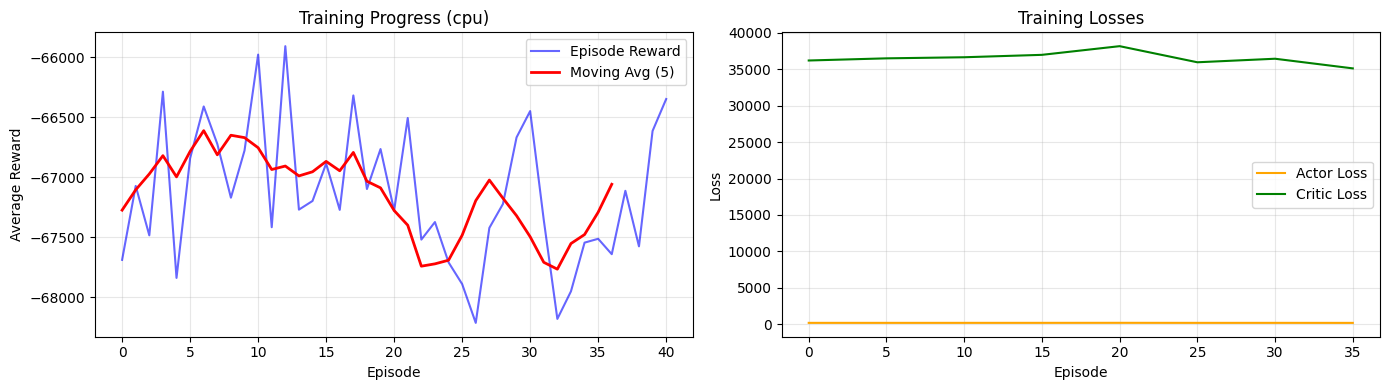


Episode 40/50 | Speed: 0.02 ep/s | ETA: 9.0m
Latest Reward: -66346.34
Avg Reward (last 10): -67382.58
Episode  45/50 | Reward: -67354.48 | Speed: 0.02 ep/s | ETA: 4.0m

✓ Training completed!
  Total time: 49.67 minutes
  Average: 59.61 sec/episode
  Speed: 0.02 episodes/second


In [41]:
# Try CPU first - should finish in 2-4 minutes
model_cpu, trainer_cpu, rewards_cpu = train_xlight_optimized(
    n_episodes=50, 
    update_interval=5, 
    plot_live=True,
    use_gpu=False  # Use CPU
)

In [43]:
model = model_cpu
trainer = trainer_cpu
rewards = rewards_cpu

In [ ]:
# RUN THIS CELL TO START TRAINING
model, trainer, rewards = train_xlight(n_episodes=50, update_interval=5, plot_live=True)

✓ Model created on mps
  Total parameters: 954,377
✓ Trainer initialized on device: mps:0

Starting training...
Episode 5/50 | Reward: -67278.58 | Steps: 360 | Speed: 0.01 ep/s
  Actor Loss: 191.7553 | Critic Loss: 37273.6973
  Pred Loss: 8.4842 | Entropy: 2.0735


KeyboardInterrupt: 

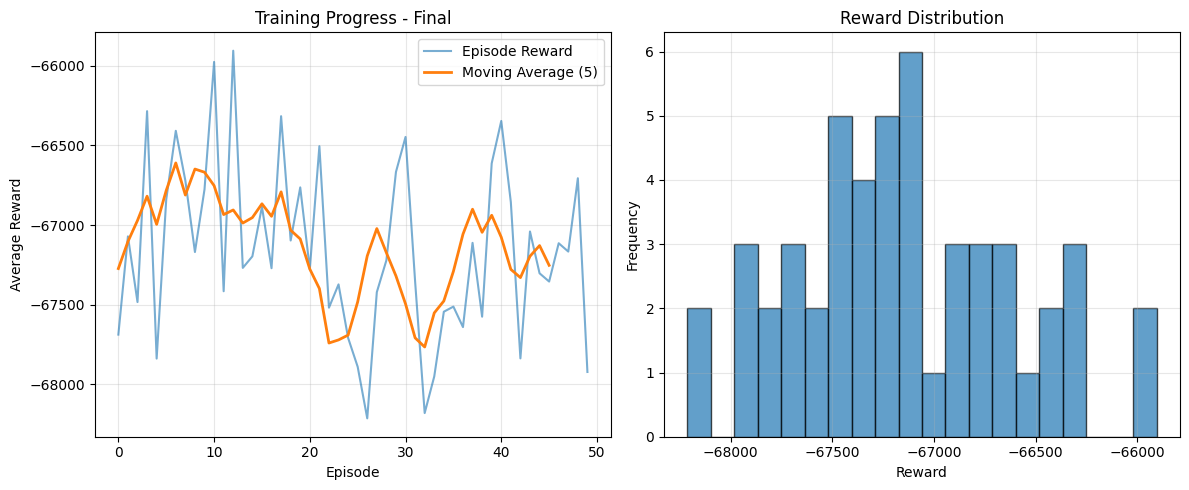

Final Statistics:
  Mean Reward: -67154.76
  Std Reward: 543.50
  Best Reward: -65905.62
  Worst Reward: -68213.09


In [44]:
# Plot final results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards, label='Episode Reward', alpha=0.6)
plt.plot(np.convolve(rewards, np.ones(5)/5, mode='valid'), 
         label='Moving Average (5)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Training Progress - Final')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(rewards, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Reward Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Statistics:")
print(f"  Mean Reward: {np.mean(rewards):.2f}")
print(f"  Std Reward: {np.std(rewards):.2f}")
print(f"  Best Reward: {np.max(rewards):.2f}")
print(f"  Worst Reward: {np.min(rewards):.2f}")

In [45]:
def evaluate_model(model, env, n_episodes=5):
    """Evaluate trained model"""
    print("Evaluating model...")
    device = next(model.parameters()).device
    total_rewards = []
    n_neighbors = 4
    history_len = 10
    
    for ep in range(n_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        
        # Initialize histories
        obs_histories = {}
        action_histories = {}
        reward_histories = {}
        
        for i in range(env.n_intersections):
            obs_histories[i] = deque(maxlen=history_len)
            action_histories[i] = deque(maxlen=history_len)
            reward_histories[i] = deque(maxlen=history_len)
            
            dummy_obs = np.zeros((1 + n_neighbors, 25), dtype=np.float32)
            dummy_action = np.zeros((1 + n_neighbors, 8), dtype=np.float32)
            dummy_reward = np.zeros((1 + n_neighbors, 1), dtype=np.float32)
            
            for _ in range(history_len):
                obs_histories[i].append(dummy_obs.copy())
                action_histories[i].append(dummy_action.copy())
                reward_histories[i].append(dummy_reward.copy())
        
        all_actions_onehot = np.zeros((env.n_intersections, 8), dtype=np.float32)
        all_actions_onehot[:, 0] = 1.0
        all_rewards = np.zeros(env.n_intersections, dtype=np.float32)
        
        while not done:
            actions = []
            
            for i in range(env.n_intersections):
                neighbor_ids = env.get_neighbors(i)
                
                # Build neighbor data arrays
                obs_batch = np.zeros((1 + n_neighbors, 25), dtype=np.float32)
                action_batch = np.zeros((1 + n_neighbors, 8), dtype=np.float32)
                reward_batch = np.zeros((1 + n_neighbors, 1), dtype=np.float32)
                
                obs_batch[0] = obs[i]
                action_batch[0] = all_actions_onehot[i]
                reward_batch[0, 0] = all_rewards[i]
                
                for idx, nid in enumerate(neighbor_ids):
                    if nid >= 0:
                        obs_batch[idx + 1] = obs[nid]
                        action_batch[idx + 1] = all_actions_onehot[nid]
                        reward_batch[idx + 1, 0] = all_rewards[nid]
                
                obs_histories[i].append(obs_batch.copy())
                action_histories[i].append(action_batch.copy())
                reward_histories[i].append(reward_batch.copy())
                
                # Stack histories
                obs_hist_array = np.stack(list(obs_histories[i]), axis=0)
                act_hist_array = np.stack(list(action_histories[i]), axis=0)
                rew_hist_array = np.stack(list(reward_histories[i]), axis=0)
                
                # Move to device
                obs_hist = torch.FloatTensor(obs_hist_array).unsqueeze(0).to(device)
                act_hist = torch.FloatTensor(act_hist_array).unsqueeze(0).to(device)
                rew_hist = torch.FloatTensor(rew_hist_array).unsqueeze(0).to(device)
                current_obs_tensor = torch.FloatTensor(obs[i]).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    action_logits, _, _, _ = model(
                        obs_hist, act_hist, rew_hist, current_obs_tensor
                    )
                    action = torch.argmax(action_logits, dim=-1)
                
                actions.append(action.cpu().item())
            
            next_obs, rewards_step, done, _ = env.step(actions)
            
            all_actions_onehot = np.zeros((env.n_intersections, 8), dtype=np.float32)
            for i, a in enumerate(actions):
                all_actions_onehot[i, a] = 1.0
            
            all_rewards = rewards_step.astype(np.float32)
            obs = next_obs
            episode_reward += np.mean(rewards_step)
        
        total_rewards.append(episode_reward)
        print(f"  Eval Episode {ep+1}/{n_episodes}: Reward = {episode_reward:.2f}")
    
    print(f"\n✓ Evaluation Complete!")
    print(f"  Average Reward: {np.mean(total_rewards):.2f} ± {np.std(total_rewards):.2f}")
    return total_rewards

print("✓ Evaluation function defined (FIXED with device)")

✓ Evaluation function defined (FIXED with device)


In [46]:
evaluate_model(model, trainer.env, n_episodes=5)

Evaluating model...
  Eval Episode 1/5: Reward = -40340.61
  Eval Episode 2/5: Reward = -40421.28
  Eval Episode 3/5: Reward = -40541.54
  Eval Episode 4/5: Reward = -40334.88
  Eval Episode 5/5: Reward = -40327.35

✓ Evaluation Complete!
  Average Reward: -40393.13 ± 81.60


[np.float32(-40340.61),
 np.float32(-40421.28),
 np.float32(-40541.54),
 np.float32(-40334.883),
 np.float32(-40327.35)]